In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
#import libraries
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [3]:
#loading the dataset
df = pd.read_csv('/content/drive/MyDrive/Handwritten-Captcha-Solver/char_dataset.csv')

In [4]:
print(df.shape)
df.head()

(130608, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23


13


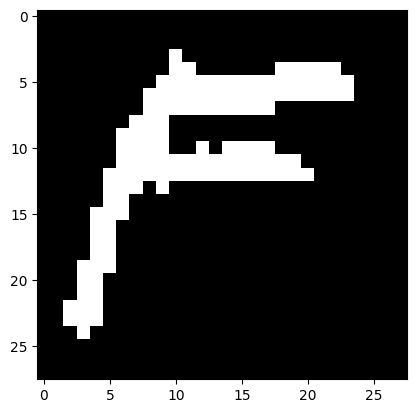

In [5]:
#printing an image
img = np.array(df.iloc[0,0:784])
img = img.reshape(28,28)
plt.imshow(img , cmap = 'gray')
#print label
print(df.iloc[0,784])

In [6]:
x = torch.from_numpy(np.array(df.iloc[:,0:784]))
y = torch.from_numpy(np.array(df.iloc[:,784]))

In [7]:
#reshaping the images
x_i = x.reshape([x.shape[0] , 1, 28 , 28])
y_i = y.reshape([y.shape[0] ,1])

In [8]:
# #splitting the data into training and validation set (25%)

train_x = x_i[:97956 , : , : , :]
train_y = y_i[:97956,:]

val_x = x_i[97956: , : , : ,:]
val_y = y_i[97956: ,:]

# print(train_x.dtype)
# print(train_y.dtype)

In [9]:
#image_preprocessing

transform  = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0,0,0),(1,1,1))])
batch_size = 36
train_x_ld = torch.utils.data.DataLoader(train_x, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
train_y_ld = torch.utils.data.DataLoader(train_y, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
val_x_ld = torch.utils.data.DataLoader(val_x, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
val_y_ld = torch.utils.data.DataLoader(val_y, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

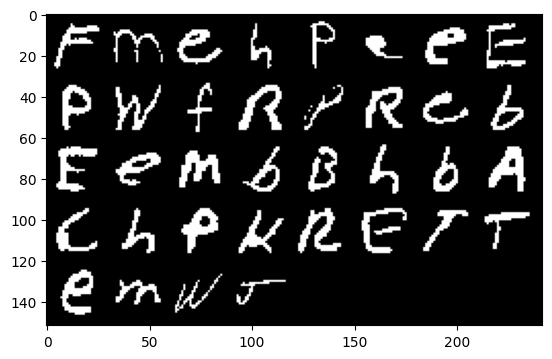

tensor([13]) tensor([20]) tensor([38]) tensor([41]) tensor([23]) tensor([38]) tensor([38]) tensor([12]) tensor([23]) tensor([30]) tensor([13]) tensor([25]) tensor([23]) tensor([25]) tensor([10]) tensor([35]) tensor([12]) tensor([38]) tensor([20]) tensor([35]) tensor([9]) tensor([41]) tensor([35]) tensor([8]) tensor([10]) tensor([41]) tensor([23]) tensor([18]) tensor([25]) tensor([12]) tensor([27]) tensor([27]) tensor([38]) tensor([20]) tensor([30]) tensor([17])


In [10]:
#printing some random images
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter_x = iter(train_x_ld)
dataiter_y = iter(train_y_ld)
images = next(dataiter_x)
labels = next(dataiter_y)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{labels[j]}' for j in range(batch_size)))


In [11]:
#device on which the model will be trainined
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [12]:
#Using a convolutional neural network
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1 = nn.Conv2d(1,32,5)
    self.conv2 = nn.Conv2d(32,32,5)
    self.conv3 = nn.Conv2d(32,64,4)
    # self.bn1 = nn.BatchNorm2d(8)
    self.pool = nn.MaxPool2d(2,2)

    # self.conv3 = nn.Conv2d(8,16,5,padding = 2)
    # self.bn2 = nn.BatchNorm2d(16)
    # # self.conv3 = nn.Conv2d(6,12,5)
    # # self.bn3 = nn.BatchNorm2d(12)
    # # self.conv4 = nn.Conv2d(12,16,7)
    # # self.bn4 = nn.BatchNorm2d(16)
    self.fc1 = nn.Linear(64,256)
    self.fc2 = nn.Linear(256,128)
    self.fc3 = nn.Linear(128,64)
    self.fc4 = nn.Linear(64,60)

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.conv3(x)
    # # x = self.pool(self.bn4(F.relu(self.conv4(x))))
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    return x

In [13]:
net = Net().to(device)

In [14]:
import torch.optim as optim

#loss function
# Cross Entropy Loss
error =  nn.CrossEntropyLoss()#loss

#optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001)


In [15]:
#CNN model training
from torch.autograd import Variable
from tqdm.notebook import tqdm

num_epoch = 36
loss_list = []
accuracy_list = []

for epoch in tqdm(range(num_epoch)):
  correct = 0
  total = 0
  dataiter_x = iter(train_x_ld)
  dataiter_y = iter(train_y_ld)
  for (images, labels) in zip(train_x_ld,train_y_ld):
    #loading the dataset
    images = images.float()
    labels = labels.reshape(labels.shape[0])
    images = Variable(images).to(device)
    labels = Variable(labels).to(device)

    # print(labels.shape)
    # print(type(labels))
    # print(labels.dtype)
    # data = image.to(torch.float32)
    # label = dataiter_y.next()
    # label = label.to(torch.float32)

    # data = Variable(data).to(device)
    # label = Variable(label).to(device)

    #Forward propagation
    # result = []
    # output = net(data)
    # for i in range(output.shape[0]):
    #   r=torch.argmax(output[i,:])
    #   result.append(r)
    # result = torch.tensor(result)
    # result = result.reshape(4,1)
    # result = result.float()
    # print(result.dtype)
    # print(label.dtype)
    #Forward propagation
    outputs = net(images)

    #loss evaluation
    outputs = nn.Softmax(dim = 1)(outputs)
    # print(outputs.shape)
    # print(type(output))
    # print(output.dtype)
    # outputs = torch.max(outputs.data , 1)[1]
    # outputs = outputs.reshape(outputs.shape[0],1)
    loss =error( outputs,labels)

#    loss =error(outputs, labels)
    #calculating gradient
    loss.backward()

    #Updating Parameters
    optimizer.step()

    #Clear Gradient
    optimizer.zero_grad()

    #Total number of label
    total += len(labels)

    #predicted value
    # predicted  = result.to(torch.int32)
    predicted = torch.max(outputs.data , 1)[1]

    #total number of correct predictions
    correct += (predicted == labels).sum()
    # l= (predicted==label)
    # if(i%100== 0):
    #   print(f'Output : {output}\nLabel : {label}')

    accuracy = 100*(correct/float(total))
  #store loss
  loss_list.append(loss.data.cpu())
  accuracy_list.append(accuracy.cpu())

  print('Iteration: {}  Loss: {} Accuracy: {}%  Correct: {} Total: {}'.format(epoch, loss.data,accuracy,correct,total))
print('Done!')



  0%|          | 0/36 [00:00<?, ?it/s]

Iteration: 0  Loss: 3.615731954574585 Accuracy: 35.485321044921875%  Correct: 34760 Total: 97956
Iteration: 1  Loss: 3.607656240463257 Accuracy: 50.99738693237305%  Correct: 49955 Total: 97956
Iteration: 2  Loss: 3.5327963829040527 Accuracy: 56.17828369140625%  Correct: 55030 Total: 97956
Iteration: 3  Loss: 3.4241368770599365 Accuracy: 63.025238037109375%  Correct: 61737 Total: 97956
Iteration: 4  Loss: 3.380173683166504 Accuracy: 66.240966796875%  Correct: 64887 Total: 97956
Iteration: 5  Loss: 3.3876354694366455 Accuracy: 66.59520721435547%  Correct: 65234 Total: 97956
Iteration: 6  Loss: 3.372443199157715 Accuracy: 66.74935913085938%  Correct: 65385 Total: 97956
Iteration: 7  Loss: 3.332364559173584 Accuracy: 67.98460388183594%  Correct: 66595 Total: 97956
Iteration: 8  Loss: 3.3180458545684814 Accuracy: 70.56637573242188%  Correct: 69124 Total: 97956
Iteration: 9  Loss: 3.3173041343688965 Accuracy: 73.3410873413086%  Correct: 71842 Total: 97956
Iteration: 10  Loss: 3.1838297843933

In [16]:
# saving the model
# torch.save(net,'/content/drive/MyDrive/Handwritten-Captcha-Solver/model_pt.pt')

# Saving model

model_scripted = torch.jit.script(net) # Export to TorchScript
model_scripted.save('/content/drive/MyDrive/Handwritten-Captcha-Solver/model_pt.pt') # Save

# Loading model
model = torch.jit.load('/content/drive/MyDrive/Handwritten-Captcha-Solver/model_pt.pt')
model.eval()

In [20]:
# Saving model

model_scripted = torch.jit.script(net) # Export to TorchScript
model_scripted.save('/content/drive/MyDrive/Handwritten-Captcha-Solver/model_h5.h5') # Save

# Loading model
model = torch.jit.load('/content/drive/MyDrive/Handwritten-Captcha-Solver/model_h5.h5')
model.eval()

RecursiveScriptModule(
  original_name=Net
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (conv2): RecursiveScriptModule(original_name=Conv2d)
  (conv3): RecursiveScriptModule(original_name=Conv2d)
  (pool): RecursiveScriptModule(original_name=MaxPool2d)
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (fc3): RecursiveScriptModule(original_name=Linear)
  (fc4): RecursiveScriptModule(original_name=Linear)
)

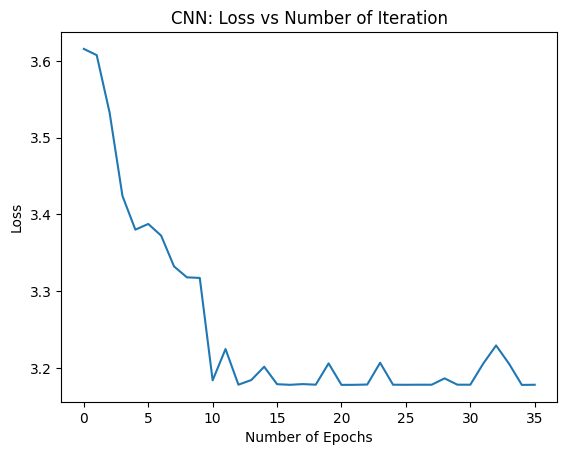

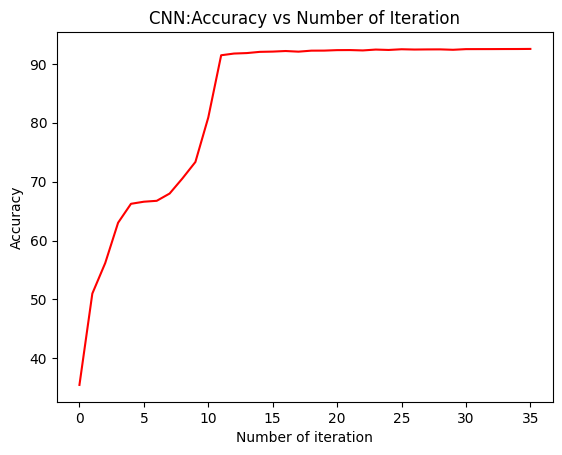

In [17]:
#visualization loss
# type(loss.data.cpu())
plt.plot(range(num_epoch) , loss_list)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('CNN: Loss vs Number of Iteration')
plt.show()

#visualizing accuracy
plt.plot(range(num_epoch),accuracy_list ,color = 'red')
plt.xlabel('Number of iteration')
plt.ylabel('Accuracy')
plt.title('CNN:Accuracy vs Number of Iteration')
plt.show()

In [18]:
correct_pred = {classname: 0 for classname in range(0,60)}
total_pred = {classname: 0 for classname in range(0,60)}
#Validating the data
with torch.no_grad():


  # dataiter_x_v = iter(val_x_ld)
  # dataiter_y_v = iter(val_y_ld)
  for (images, labels) in zip(val_x_ld,val_y_ld):
    #loading the dataset
    images = images.float()
    labels = labels.reshape(labels.shape[0])
    images = images.to(device)
    # labels = Variable(labels).to(device)
    # image = dataiter_x_v.next()
    # # print(image.shape)
    # # data = image.reshape([batch_size ,3,267,267])
    # data = image.to(torch.float32)
    # label_1 = dataiter_y_v.next()
    # label = label_1.to(torch.float32)

    # data = data.to(device)
    # label = label.to(device)

    #Forward propagation
    outputs = net(images)

    #loss evaluation
    # loss = error(output ,labels)

    #Total number of label
    total += len(labels)

    #predicted value
    predicted = torch.max(outputs.data , 1)[1]
    predicted = predicted.to('cpu')

    for label, prediction in zip(labels,predicted):
        if label == prediction:
          correct_pred[label.item()]+=1
        total_pred[label.item()] +=1

score = 0

#print accuracy for each class
for classname, correct_count in correct_pred.items():
    if total_pred[classname] !=0:
      accuracy = 100 * float(correct_count) / (total_pred[classname])
      score = score + accuracy
      print(f'Accuracy for class: {classname} is {accuracy:.1f} % from total of {total_pred[classname] }')


Accuracy for class: 1 is 63.2 % from total of 38
Accuracy for class: 2 is 0.0 % from total of 55
Accuracy for class: 3 is 0.0 % from total of 52
Accuracy for class: 4 is 69.1 % from total of 55
Accuracy for class: 5 is 0.0 % from total of 43
Accuracy for class: 6 is 0.0 % from total of 53
Accuracy for class: 7 is 97.9 % from total of 48
Accuracy for class: 8 is 97.2 % from total of 1606
Accuracy for class: 9 is 96.8 % from total of 960
Accuracy for class: 10 is 95.0 % from total of 2549
Accuracy for class: 11 is 98.2 % from total of 1097
Accuracy for class: 12 is 98.7 % from total of 1218
Accuracy for class: 13 is 98.6 % from total of 2280
Accuracy for class: 14 is 94.5 % from total of 586
Accuracy for class: 15 is 0.0 % from total of 817
Accuracy for class: 17 is 0.0 % from total of 942
Accuracy for class: 18 is 97.7 % from total of 657
Accuracy for class: 20 is 98.6 % from total of 2359
Accuracy for class: 23 is 93.9 % from total of 2067
Accuracy for class: 25 is 95.5 % from total of

In [19]:
print(score)

1881.2832460025584
